In [186]:
%matplotlib inline
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# EECS 545:  Machine Learning
## Lecture 11:  Bias-Variance Tradeoff, Cross Validation, ML Advice
* Instructor:  **Jacob Abernethy**
* Date:  February 17, 2015

*Lecture Exposition Credit: Ben & Valli*

### Today's Lecture: * Machine Learning Advice * 
- How does one go about choosing and applying an ML algorithm?
- How does one improve the performance of an ML algorithm?

### A question to ponder about
#### What is the goal of Machine Learning and ML algorithms?

Common Goal:
   - Not to learn an exact representation of the training data itself. 
   - Build a statistical model of the process which generates the data (Statistical Inference).
   - This is important if the algorithm is to have good generalization performance.

### At the beginning...

- Suppose you are given some dataser and are asked to analyze it, say as a research project.
- What is the first thing you will do once you are given this task?

In [187]:
from sklearn.datasets import make_classification
X, y = make_classification(1000, n_features=5, n_informative=2, 
                           n_redundant=2, n_classes=2, random_state=0)

from pandas import DataFrame
df = DataFrame(np.hstack((X, y[:, None])), 
               columns = range(5) + ["class"])

In [188]:
df[:5]

,0,1,2,3,4,class
0,-0.744656,-1.002108,-0.229806,0.834371,0.250114,0
1,1.798666,-0.022413,1.666616,0.980480,-0.404352,1
2,-0.940481,-1.219292,-0.311325,0.996956,-2.005125,0
3,0.567027,0.260004,0.403881,-0.018421,-1.033165,1
4,1.352852,-0.507426,1.476739,1.339058,-1.572796,1


### Basic Statistical Analysis

- Analyze the data using simple statistical measurements and tools. Particularly maybe look for:
 - Number of features? Number of classes? (for classification)
 - Mean, Median, Mode?
 - Correlation? 
 - Dataset size? Missing samples?

### Visualization

- Pro: Can often be more useful than mathematical statistical analysis to get a good grasp of what the dataset looks like.
- Con: High-dimensional data can be hard to visualize.

Some helpful visualizations for the 5-dimensional dataset follow. 

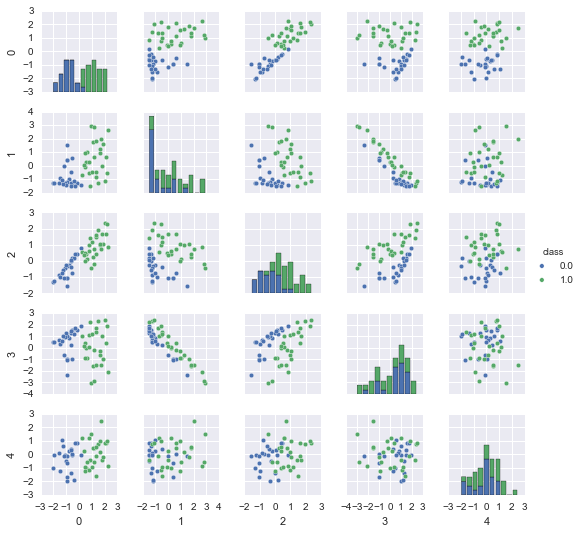

In [189]:
# Pairwise feature plot

_ = sns.pairplot(df[:50], vars=[0, 1, 2, 3, 4], hue="class", size=1.5)

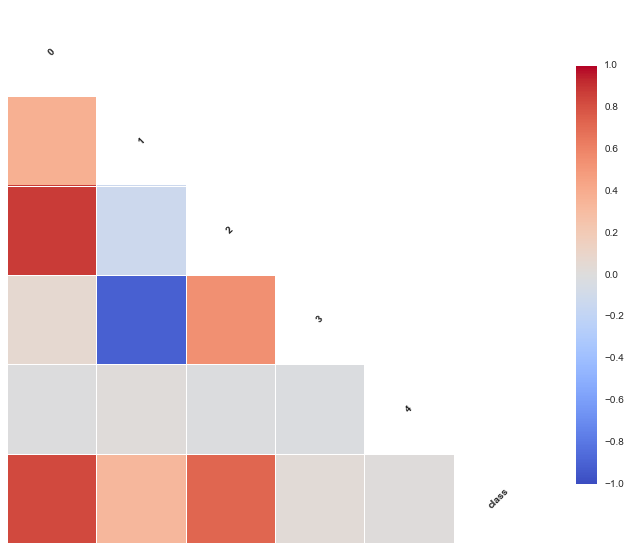

In [190]:
# Correlation Plot

plt.figure(figsize=(12, 10))
_ = sns.corrplot(df, annot=False)

### Choosing a Method

- Not easy to immediately decide what to use. Some things to consider first: 
 - Supervised vs. Unsupervised vs. Semi-supervised vs. Active Learning vs. Reinforcement Learning ...?
 - Generative vs. Discriminative? 
 - Parametric vs. Non-parametric?
 
- Still wondering how to go about choosing methods from an applied viewpoint? 
 - There are many guides (see next few slides). 
 - Go ahead and try different algorithms! We will also talk about how to measure performance and deal with poor performance later.

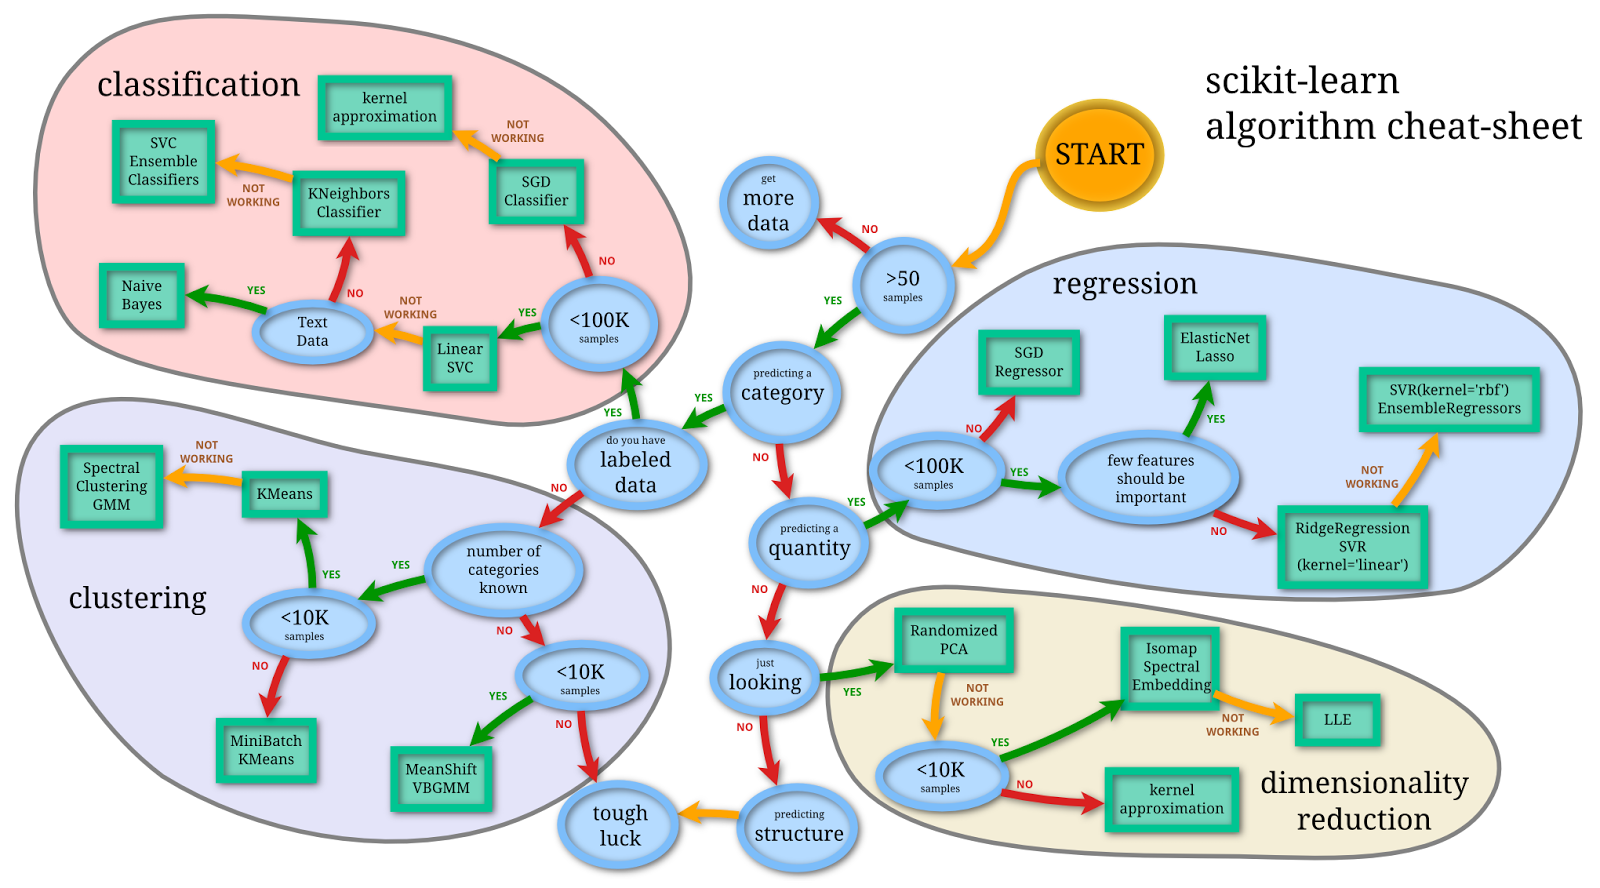

In [191]:
from IPython.display import Image
Image(filename='sklearn_sheet.png', width=800, height=600) 

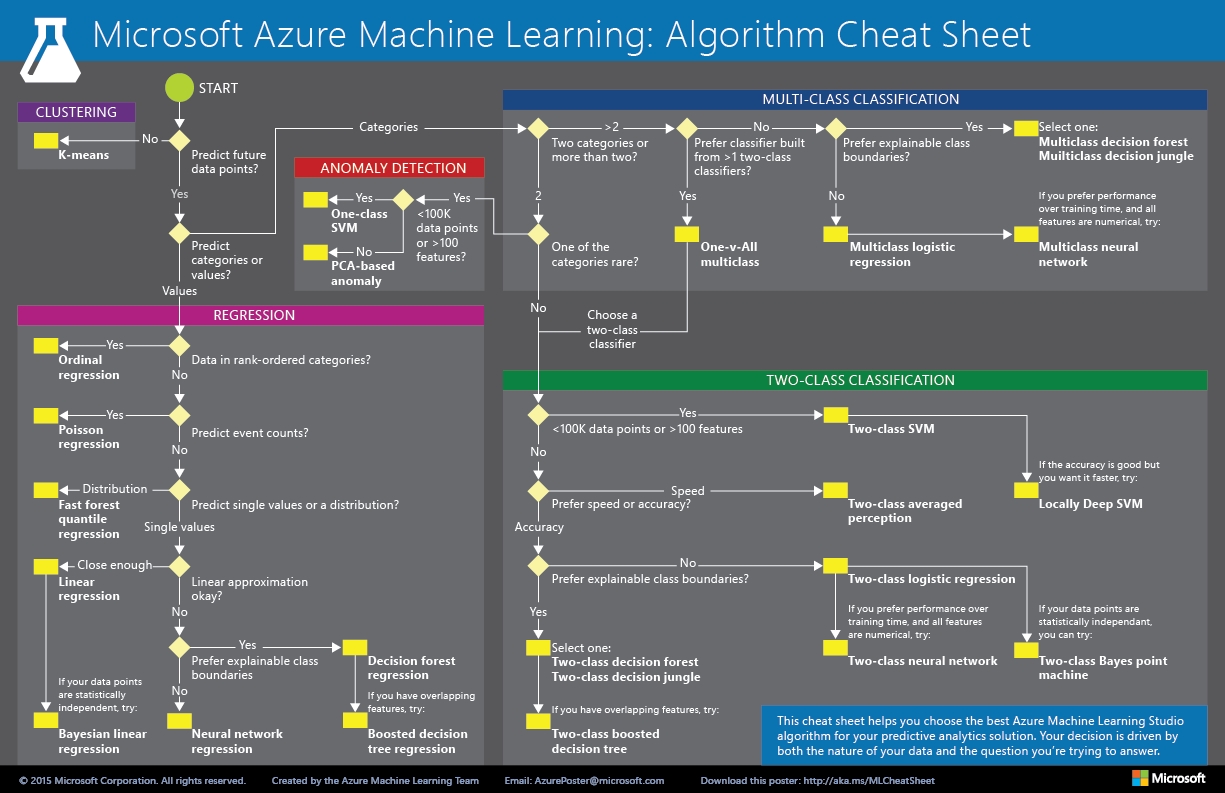

In [192]:
from IPython.display import Image
Image(filename='azure_sheet.png', width=800, height=600) 

### Building a Statistical Model (Statistical Inference) 
#### Estimators

- ML Algorithms can in general be thought of as "estimators."
- Estimator: A statistic (a function of data) that is used to infer the value of an unknown parameter in a statistical model.

- Suppose there is a fixed parameter $f$ that needs to be estimated. An estimator of $f$ is a function that maps the sample space to a set of sample estimates, denoted $\hat{f}$.

### Noise

- For most problems in Machine Learning, the relationship is functional but noisy.

- Mathematically, $y = f(x) + \epsilon$ where $\epsilon$ is noise with mean $0$ variance $\sigma^2$

### A Mathematical to view the goal of Machine Learning

- Let the training set be $D = \{\mathbf{x}_1, ..., \mathbf{x}_n\}, \mathbf{x}_i \in \mathbb{R}^d$.
- Goal: Find $\hat{f}$ that minimizes some **Loss function**, $L(y, \hat{f})$, which measures how good predictions are for **both** 
 - Points in $D$ (the **sample**), and, 
 - Points ***out of sample*** (outside $D$).
- Cannot minimize both perfectly because the relationship between $y$ and $\mathbf{x}$ is noisy.
 - ***Irreducible error***.

### Brief aside on Loss Functions (1)
- Quadratic Loss: 
 - Used in regression.
 - Influenced by outliers.
- 0-1 Loss
 - Used for classification. 
 - Not convex! 
  - Not practical since optimization problems become intractable!
- Hinge Loss
 - Used in SVMs. 
 - Robust to outliers.
 - Do not provide well calibrated probabilities.

### Brief aside on Loss Functions (2)

- Log-loss
 - Used in Logistic regression.
 - Influenced by outliers. 
 - Provides well calibrated probabilities (can be interpreted as confidence levels).
- Exponential Loss
 - Used in Boosting.
 - Very susceptible to outliers.

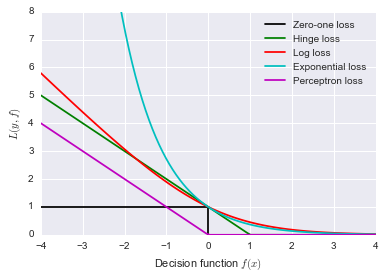

In [193]:
# adapted from http://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_loss_functions.html
xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], 'k-',
         label="Zero-one loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0), 'g-',
         label="Hinge loss")
plt.plot(xx, np.log2(1 + np.exp(-xx)), 'r-',
         label="Log loss")
plt.plot(xx, np.exp(-xx), 'c-',
         label="Exponential loss")
plt.plot(xx, -np.minimum(xx, 0), 'm-',
         label="Perceptron loss")
plt.ylim((0, 8))
plt.legend(loc="upper right")
plt.xlabel(r"Decision function $f(x)$")
plt.ylabel("$L(y, f)$")

### Risk

For a given Loss Function, we can calculate a "Risk" function that gives the expected loss or error (this is calculated in different ways depending on whether a frequentist or bayesian approach is taken). See Nikulin, M.S. (2001), Robert Christian (2007) for more details.

To simplify the explanations for the next few slides and introduce the Bias-Variance decomposition, we will consider the quadratic loss function, $L(y, \hat{f}) = (y - \hat{f})^2$, whose associated risk function is simply given by $\mathbb{E}[(y - \hat{f})^2]$.

Thus, let the expected error of an estimator $\hat{f}$ be given by $\mathbb{E}[(y - \hat{f})^2]$.

We can now go on to expand the above expression. 

### Decomposing the expected error (1)

$\mathbb{E}[(y - \hat{f})^2] = \mathbb{E}[y^2 - 2 \cdot y \cdot \hat{f} + {\hat{f}}^2]$

By linearity of expectations, we then have: 

$\mathbb{E}[(y - \hat{f})^2] = \mathbb{E}[y^2] - \mathbb{E}[2 \cdot y \cdot \hat{f}] + \mathbb{E}[{\hat{f}}^2]$

### Decomposing the expected error (2)

$\mathbb{E}[(y - \hat{f})^2] = \mathbb{E}[y^2] - \mathbb{E}[2 \cdot y \cdot \hat{f}] + \mathbb{E}[{\hat{f}}^2]$

Now, $Var[X] = \mathbb{E}[{X}^2] - {\mathbb{E}[X]}^2$

So, $\mathbb{E}[X^2] = Var[X] + {\mathbb{E}[X]}^2$

Thus, we have $\mathbb{E}[(y - \hat{f})^2] = Var[y] + {\mathbb{E}[y]}^2 - \mathbb{E}[2 \cdot y \cdot \hat{f}] + Var[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2$

### Decomposing the expected error (3)

$\mathbb{E}[(y - \hat{f})^2] = Var[y] + {\mathbb{E}[y]}^2 - \mathbb{E}[2 \cdot y \cdot \hat{f} + Var[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2$

$\begin{align} \mathbb{E}[y] &= \mathbb{E}[f + \epsilon] \\
               &= \mathbb{E}[f] + \mathbb{E}[\epsilon] \text{ (linearity of expectations)}\\
               &= \mathbb{E}[f] + 0 \\
               &= f \text{ (} \because f \text{ is determinstic)}\end{align}$
               
$\begin{align} Var[y] &= \mathbb{E}[(y - \mathbb{E}[y])^2] \\
                      &= \mathbb{E}[(y - f)^2] \\
                      &= \mathbb{E}[(f + \epsilon - f)^2] \\
                      &= \mathbb{E}[\epsilon^2] = \sigma^2 \end{align}$
                

Thus, $\mathbb{E}[(y - \hat{f})^2] = \sigma^2 + f^2 - \mathbb{E}[2 \cdot y \cdot \hat{f}] + Var[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2$

### Decomposing the expected error (4)

$\mathbb{E}[(y - \hat{f})^2] = \sigma^2 + f^2 - \mathbb{E}[2 \cdot y \cdot \hat{f}] + Var[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2$

Note that $y$ is random ***only*** in $\epsilon$ (again, $f$ is deterministic). 

Also, $\epsilon$ is ***independent*** from $\hat{f}$.

$\begin{align}\text{Hence, }  \mathbb{E}[2 \cdot y \cdot \hat{f}] 
                      &= \mathbb{E}[2 \cdot y \cdot \hat{f}]\\
                      &= \mathbb{E}[2 \cdot y] \cdot \mathbb{E}[\hat{f}] \text{ (by independence) }\\
                      &= 2 \cdot \mathbb{E}[y] \cdot \mathbb{E}[\hat{f}] \\
                      &= 2 \cdot f \cdot \mathbb{E}[\hat{f}] \end{align}$
   
Thus, we now have $\mathbb{E}[(y - \hat{f})^2] = \sigma^2 + f^2 - 2 \cdot f \cdot \mathbb{E}[\hat{f}] + Var[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2$

### Decomposing the expected error (5)

$\mathbb{E}[(y - \hat{f})^2] = \sigma^2 + Var[\hat{f}] + f^2 - 2 \cdot f \cdot \mathbb{E}[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2$

Now, $f^2 - 2 \cdot f \cdot \mathbb{E}[\hat{f}] + \mathbb{E}[\hat{f}]^2 = (f - \mathbb{E}[\hat{f}])^2$ 

$\implies \mathbb{E}[(y - \hat{f})^2] = \sigma^2 + Var[\hat{f}] + (f - \mathbb{E}[\hat{f}])^2$

$\begin{align} \text{Finally, } \mathbb{E}[f - \hat{f}] 
                        &= \mathbb{E}[f] - \mathbb{E}[\hat{f}] \text{ (linearity of expectations)} \\
                        &= f - \mathbb{E}[\hat{f}] \end{align}$
                     
So, $\mathbb{E}[(y - \hat{f})^2] = \sigma^2 + Var[\hat{f}] + {\mathbb{E}[f - \hat{f}]}^2$

### Bias-Variance Decomposition

$\mathbb{E}[(y - \hat{f})^2] = \underbrace{{\sigma^2}}_\text{irreducible error} + \overbrace{{Var[\hat{f}]}}^\text{Variance} + \underbrace{{\mathbb{E}[f - \hat{f}]}^2}_{\text{Bias}^2}$

### An example to explain Bias/Variance and illustrate the tradeoff 

- Consider estimating a sinusoidal function.

In [194]:
import pylab as pl
def plot_fit(x, y, p):
    xfit = np.linspace(0, 2, 1000)
    yfit = np.polyval(p, xfit)
    pl.scatter(x, y, c='k')
    pl.plot(xfit, yfit)
    pl.hold('on')
    pl.xlabel('x')
    pl.ylabel('y')

In [210]:
def polyfit_sin(degree, iterations):
    total = 0
    l = []
    avg_coeff = []
    for i in range(iterations):
        np.random.seed()
        x = 2 * np.random.random(2) # Pick 2 random points from the sinusoid with co-domain [0, 2)
        y = np.sin(np.pi * x)
        p = np.polyfit(x, y, degree)  
        y_poly = [np.polyval(p, x_i) for x_i in x]  
        plot_fit(x, y, p)
        total += sum(abs(y_poly - y) ** 2) # calculate Squared Error (Squared Error) 
        l.append(sum(abs(y_poly - y) ** 2))
        avg_coeff.append(p)
    return total / iterations, np.var(l), np.mean(avg_coeff, axis = 0)

(0.00013324199317659219, 0.0, array([-0.97601663]))


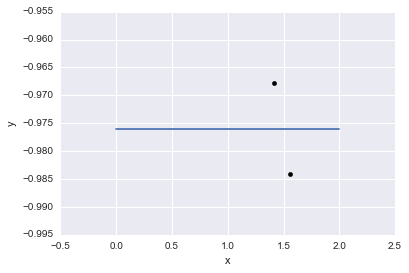

In [211]:
print(polyfit_sin(0, 1))

(0.2133584217438754, 0.014669724713288751)


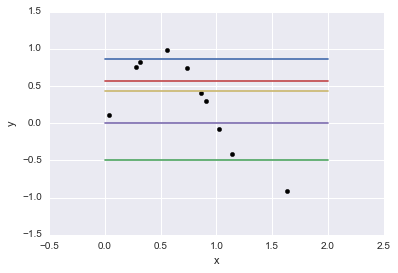

In [197]:
print(polyfit_sin(0, 5))

(0.54078913324104083, 0.32554365686692033)


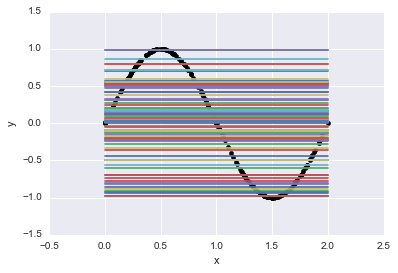

In [198]:
print(polyfit_sin(0, 100))

(0.49605295486563972, 0.31616143702587585, array([-0.02582717]))


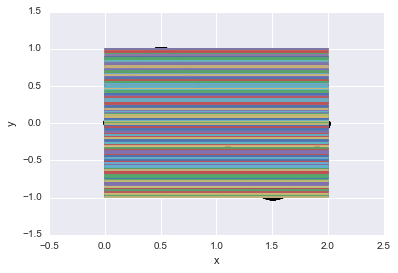

In [224]:
print(polyfit_sin(0, 500))

(1.3973705082123114e-30, 0.0, array([-2.72952978,  2.7278222 ]))


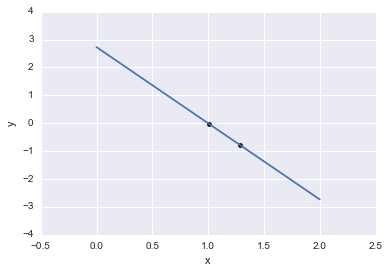

In [212]:
print(polyfit_sin(1, 1))

(5.5050781530364751e-31, 4.2400359248218569e-61, -0.18913149679090502)


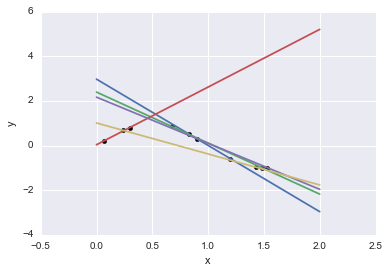

In [209]:
print(polyfit_sin(1, 5))

(7.0196166155003317e-31, 3.8334624602379954e-60)

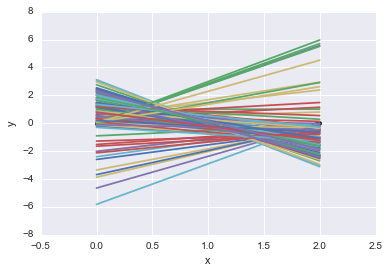

In [202]:
polyfit_sin(1, 100)

(8.1324166175291756e-31,
 2.046573464515201e-60,
 array([-0.77007286,  0.81439819]))

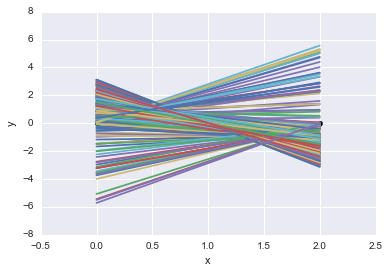

In [220]:
polyfit_sin(1, 250)

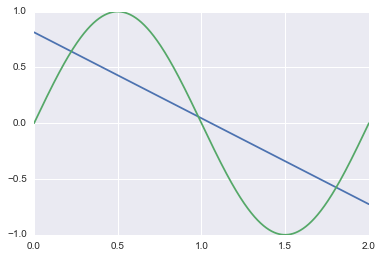

In [223]:
p = np.poly1d([-0.77007286,  0.81439819])
x = np.linspace(0, 2, 1000)
y = [np.polyval(p, x_i) for x_i in x] 
sin_ = np.sin(np.pi * x)
plt.plot(x, y)
plt.plot(x, sin_)

In [ ]:
### 

### Model Selection 

- ML Algorithms generally have a lot of parameters that must be chosen. A natural question is then "How do we choose them?"

- 

### Hold-Out Cross Validation 

(1) Randomly split the training data $D$ into $D_{train}$ and $D_{val}$, say 70% of the data and 30% of the data respectively.

(2) Train each model $M_i$ on $D_{train}$ only, each time getting a hypothesis $h_i$.

(3) Select and output hypothesis $h_i$ that had the smallest error on the held out validation set.

Disadvantages: 
 - Waste some sizable amount of data (30\% in the above scenario) so that less training examples are available.
 - Using only some data for training and other data for validation.

### K-Fold Cross Validation (Step 1)

Randomly split the training data $D$ into $K$ ***disjoint*** subsets of $N/K$ training samples each.
 - Let these subsets be denoted $D_1, ..., D_K$.

### K-Fold Cross Validation (Step 2)

For each model $M_i$, we evaluate the model as follows: 
 - Train the model $M_i$ on $D \setminus D_k$ (all of the subsets except subset $D_k$) to get hypothesis $h_i(k)$.
 - Test the hypothesis $h_i(k)$ on $D_k$ to get the error (or loss) $\epsilon_i(k)$.
 - Estimated generalization error for model $M_i$ is then given by $e^g_i = \frac{1}{K} \sum \limits_{k = 1}^K \epsilon_i (k)$

### K-Fold Cross Validation (Step 3)

Pick the model $M_i^*$ with the lowest estimated generalization error $e^{g*}_i$ and retrain the model on the entire training set, thus giving the final hypothesis $h^*$ that is output.

### Three Way Data Splits

- If model selection and true error estimates are to be computed simaltaneously, the data needs to be divided into three disjoin sets.

- Training set: A set of examples used for learning
- Validation set: A set of examples used to tune the hyperparameters of a classifier.
- Test Set: A set of examples used *** only *** to assess the performance of a fully-trained model.

### Procedure Outline

1. Divide the available data into training, validation and test set
2. Select a model (and hyperparameters)
3. Train the model using the training set
4. Evaluate the model using the validation set
5. Repeat steps 2 through 4 using different models (and hyperparameters)
6. Select the best model (and hyperparameter) and train it using data from the training and validation set
7. Assess this final model using the test set